In [2]:
# Are we using a GPU?
!nvidia-smi

Sat Jun  5 07:44:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Get data (10% of labels)
import zipfile

# Download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2021-06-05 07:46:32--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.73.208, 172.253.115.128, 172.253.122.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.73.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   222MB/s    in 0.7s    

2021-06-05 07:46:32 (222 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [4]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/gri

In [6]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


In [7]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [8]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [9]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# EfficientNet0 feature vector
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [10]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

# **1.1- New Resnet_model-train_data_10_percent**

In [11]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [12]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20210605-075214
Epoch 1/5
24/24 [==============================] - 51s 780ms/step - loss: 1.9517 - accuracy: 0.3400 - val_loss: 1.2118 - val_accuracy: 0.6196
Epoch 2/5
24/24 [==============================] - 15s 664ms/step - loss: 0.8887 - accuracy: 0.7280 - val_loss: 0.8457 - val_accuracy: 0.7376
Epoch 3/5
24/24 [==============================] - 24s 1s/step - loss: 0.6035 - accuracy: 0.8333 - val_loss: 0.7419 - val_accuracy: 0.7632
Epoch 4/5
24/24 [==============================] - 16s 666ms/step - loss: 0.4660 - accuracy: 0.8773 - val_loss: 0.7138 - val_accuracy: 0.7668
Epoch 5/5
24/24 [==============================] - 16s 672ms/step - loss: 0.3755 - accuracy: 0.9133 - val_loss: 0.6762 - val_accuracy: 0.7868


In [13]:
# Resnet summary 
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [14]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

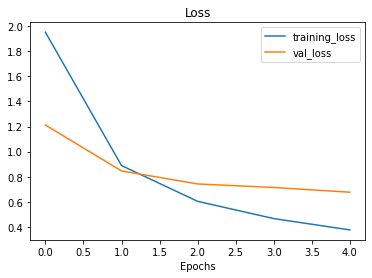

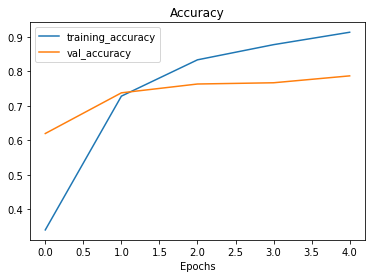

In [15]:
plot_loss_curves(resnet_history)

# **1.2-efficientnet_model--train_data_10_percent**

In [18]:
efficientnet_model = create_model(model_url=efficientnet_url, num_classes= train_data_10_percent.num_classes)
 
efficientnet_model.compile(loss = 'categorical_crossentropy',
                            optimizer = tf.keras.optimizers.Adam(),
                            metrics = ['accuracy'])
efficientnet_history = efficientnet_model.fit(train_data_10_percent, 
                                              epochs = 5, 
                                              steps_per_epoch = len(train_data_10_percent), 
                                              validation_data = test_data,
                                              validation_steps = len(test_data),
                                              callbacks = [create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                      experiment_name = "efficientnetB0")]) 

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20210605-080642
Epoch 1/5
24/24 [==============================] - 26s 809ms/step - loss: 1.9198 - accuracy: 0.4160 - val_loss: 1.3448 - val_accuracy: 0.7120
Epoch 2/5
24/24 [==============================] - 15s 628ms/step - loss: 1.0932 - accuracy: 0.7880 - val_loss: 0.8826 - val_accuracy: 0.8128
Epoch 3/5
24/24 [==============================] - 14s 620ms/step - loss: 0.7721 - accuracy: 0.8467 - val_loss: 0.7042 - val_accuracy: 0.8372
Epoch 4/5
24/24 [==============================] - 14s 619ms/step - loss: 0.6171 - accuracy: 0.8680 - val_loss: 0.6134 - val_accuracy: 0.8532
Epoch 5/5
24/24 [==============================] - 14s 615ms/step - loss: 0.5187 - accuracy: 0.8893 - val_loss: 0.5573 - val_accuracy: 0.8616


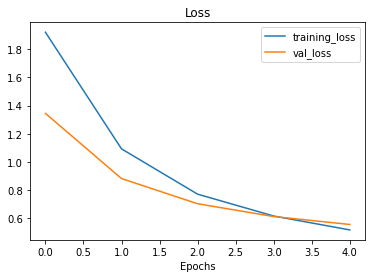

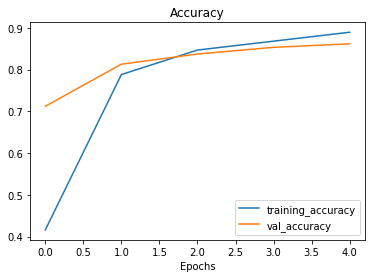

In [19]:

plot_loss_curves(efficientnet_history)

In [20]:
efficientnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


# **Upload TensorBoard dev records**

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot

In [ ]:
# Check out experiments
!tensorboard dev list

In [35]:
# Delete an experiment
# !tensorboard dev delete --experiment_id n6kd8XZ3Rdy1jSgSLH5WjA

# **1.3-Mobilenet_v2_100_224**

In [24]:
mobilenet_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"

In [28]:
mobilenet_model = create_model(model_url=mobilenet_url, num_classes= train_data_10_percent.num_classes)
 
mobilenet_model.compile(loss = 'categorical_crossentropy',
                            optimizer = tf.keras.optimizers.Adam(),
                            metrics = ['accuracy'])
mobilenet_history = mobilenet_model.fit(train_data_10_percent, 
                                              epochs = 5, 
                                              steps_per_epoch = len(train_data_10_percent), 
                                              validation_data = test_data,
                                              validation_steps = len(test_data),
                                              callbacks = [create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                                      experiment_name = "mobilenet_v2_100_224")]) 

Saving TensorBoard log files to: tensorflow_hub/mobilenet_v2_100_224/20210605-081741
Epoch 1/5
24/24 [==============================] - 20s 679ms/step - loss: 1.8452 - accuracy: 0.3827 - val_loss: 1.1857 - val_accuracy: 0.6572
Epoch 2/5
24/24 [==============================] - 14s 619ms/step - loss: 0.9537 - accuracy: 0.7440 - val_loss: 0.8446 - val_accuracy: 0.7576
Epoch 3/5
24/24 [==============================] - 24s 1s/step - loss: 0.6983 - accuracy: 0.8107 - val_loss: 0.7262 - val_accuracy: 0.7812
Epoch 4/5
24/24 [==============================] - 14s 614ms/step - loss: 0.5494 - accuracy: 0.8720 - val_loss: 0.6536 - val_accuracy: 0.8048
Epoch 5/5
24/24 [==============================] - 14s 596ms/step - loss: 0.4605 - accuracy: 0.9040 - val_loss: 0.6301 - val_accuracy: 0.7992


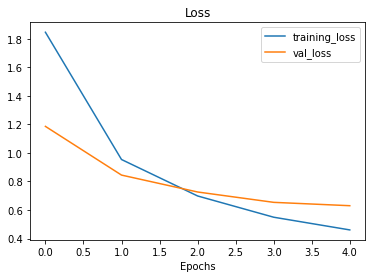

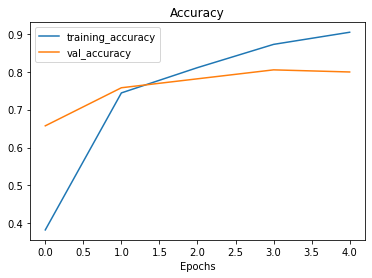

In [29]:

plot_loss_curves(mobilenet_history)

In [30]:
mobilenet_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              2257984   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________


# **Comparing_3_different_model**

In [31]:
# Check out experiments
!tensorboard dev list

2021-06-05 08:20:58.569923: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
https://tensorboard.dev/experiment/6K664M2BSeCgkauk6eYHOA/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models architectures using 10% of training images
	Id                   6K664M2BSeCgkauk6eYHOA
	Created              2021-06-05 08:08:49 (12 minutes ago)
	Updated              2021-06-05 08:08:51 (12 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  6086643
Total: 1 experiment(s)


In [32]:
# Delete an experiment
!tensorboard dev delete --experiment_id 6K664M2BSeCgkauk6eYHOA

2021-06-05 08:21:31.704414: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
Deleted experiment 6K664M2BSeCgkauk6eYHOA.


In [33]:
# Check out experiments
!tensorboard dev list

2021-06-05 08:21:47.475169: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
No experiments. Use `tensorboard dev upload` to get started.


In [34]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2 vs. Mobilenet_v2" \
  --description "Comparing three different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot

2021-06-05 08:22:46.416487: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.

New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/wQQHNZiORgyMhoPHEM7qvw/

[2021-06-05T08:22:47] Started scanning logdir.
[2021-06-05T08:22:50] Total uploaded: 90 scalars, 0 tensors, 3 binary objects (7.5 MB)
[2021-06-05T08:22:50] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/wQQHNZiORgyMhoPHEM7qvw/


# Done. View your TensorBoard at https://tensorboard.dev/experiment/wQQHNZiORgyMhoPHEM7qvw/

In [36]:
# Check out experiments
!tensorboard dev list

2021-06-05 08:23:59.578108: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
https://tensorboard.dev/experiment/wQQHNZiORgyMhoPHEM7qvw/
	Name                 EfficientNetB0 vs. ResNet50V2 vs. Mobilenet_v2
	Description          Comparing three different TF Hub feature extraction models architectures using 10% of training images
	Id                   wQQHNZiORgyMhoPHEM7qvw
	Created              2021-06-05 08:22:47 (1 minute ago)
	Updated              2021-06-05 08:22:50 (1 minute ago)
	Runs                 6
	Tags                 5
	Scalars              90
	Tensor bytes         0
	Binary object bytes  7865795
Total: 1 experiment(s)
